In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
import pickle
from typing import DefaultDict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True


In [9]:
### Helper

from matplotlib import transforms


def draw_dodge(*args, **kwargs):
    func = args[0]
    dodge = kwargs.pop("dodge", 0)
    ax = kwargs.pop("ax", plt.gca())
    trans = ax.transData  + transforms.ScaledTranslation(dodge/72., 0,
                                   ax.figure.dpi_scale_trans)
    artist = func(*args[1:], **kwargs)
    def iterate(artist):
        if hasattr(artist, '__iter__'):
            for obj in artist:
                iterate(obj)
        else:
            artist.set_transform(trans)
    iterate(artist)
    return artist


In [10]:
# load the results

# results_file = open('../results/meta_perf_vs_num_feats_fixed.pkl', 'rb')
results_file = open('/Users/zzzzzz/Downloads/meta_perf_vs_num_feats_fixed.pkl', 'rb')  # new file
# results_file = open('/Users/zzzzzz/Downloads/meta_perf_vs_num_feats_fixed_5trials.pkl', 'rb')  # new file
all_results = pickle.load(results_file)
results_file.close()

In [43]:
# (num_trials is just used to verify all evaluations succeeded)
num_trials = 50
metric = "perc_diff_from_best_global"
#metric = 'mae'
NUM_FEATS_LIST = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
# the way this is done now, this needs to exactly match the range from the python file that generated the pickle file.
# NUM_FEATS_LIST = [1, 2, 3, 6, 10, 19, 35, 64, 117, 211, 382]
# NUM_FEATS_LIST = [2, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40]
# computed using 
# [int(j) for j in np.logspace(start=0.9, stop=np.log(382)/np.log(2), num=10, endpoint=True, base=2.0)]
# and then adding "2"

models = ['xgboost', 'random', 'knn', 'linear']

In [44]:
results_per_model = {model: DefaultDict(list) for model in models}
for dataset in all_results:
    for trial in all_results[dataset]:
        num_feats = all_results[dataset][trial]['num_feats']
        for model in all_results[dataset][trial]:
            # note: it's not so safe to do this, where we throw away the the num_* and hard-code it later.
            if model in ['num_train', 'num_algs', 'num_feats']: continue
            for n_feats, perf in zip(num_feats, all_results[dataset][trial][model]):
                results_per_model[model][n_feats].append(perf[metric])

In [45]:
multiply_factor = 100.0

means = {}
medians = {}
p1s = {}
p3s = {}
for model in models:
    means[model] = []
    medians[model] = []
    p1s[model] = []
    p3s[model] = []
    # needs to match the range in the python file
    for n_feats in NUM_FEATS_LIST:
        assert len(results_per_model[model][n_feats]) == 19 * num_trials, print(f"it looks like num trials is: {len(results_per_model[model][n_feats])/19.0} for model={model}, n_feats={n_feats}")
        means[model].append(multiply_factor * np.mean(results_per_model[model][n_feats]))
        medians[model].append(multiply_factor * np.median(results_per_model[model][n_feats]))
        p1s[model].append(multiply_factor * np.percentile(results_per_model[model][n_feats], 40))
        p3s[model].append(multiply_factor * np.percentile(results_per_model[model][n_feats], 60))


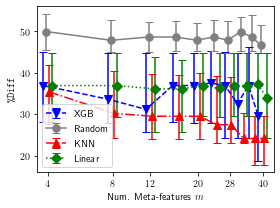

In [48]:
method_dict = {
    "xgboost": {
        "name": "XGB",
        "kwargs": {
            "marker": "v",
            "color": "blue",
            "linestyle": "--",
        }
    },
    "linear": {
        "name": "Linear",
        "kwargs": {
            "marker": "D",
            "color": "green",
            "linestyle": ":",
        }
    },    
    "knn": {
        "name": "KNN",
        "kwargs": {
            "marker": "^",
            "color": "red",
            "linestyle": "-.",
        }
    },
    "random": {
        "name": "Random",
        "kwargs": {
            "marker": "o",
            "color": "gray",
            "linestyle": "-",
        }
    }
}


dodge = np.arange(4,dtype=float)*3
dodge -= dodge.mean()


# plot %Diff
metric = "perc_diff_from_best_global"
y_axis_label = "\\texttt{\\%Diff}"


# plot with fill between 40-60% of trials

x = NUM_FEATS_LIST

fig, ax = plt.subplots(figsize=(4, 3))

for i,model in enumerate(models):
    # plt.plot(x, medians[model], label=method_dict[model]["name"], **method_dict[model]["kwargs"])
    # plt.fill_between(x, p1s[model], p3s[model], alpha=0.1, color=method_dict[model]["kwargs"]["color"])
    yerr = np.array([(x - small, large - x) for x, small, large in zip(medians[model], p1s[model], p3s[model])]).T
    # err_minus = [x - small for m, small in zip(medians[model], p1s[model])]
    # plt.errorbar(x, medians[model], yerr=yerr, capsize=4, **method_dict[model]["kwargs"])
    draw_dodge(ax.errorbar, x, medians[model], yerr=yerr, ax=ax, dodge=dodge[i], capsize=4, markersize=7.5, label=method_dict[model]["name"], **method_dict[model]["kwargs"])


matplotlib.rcParams['xtick.minor.size'] = 0
matplotlib.rcParams['xtick.minor.width'] = 0

plt.xscale('log')
# ax.set_xticks([5, 10, 50])
ax.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
# ax.set_xticks( np.geomspace(4, 40 ,10).round())
ax.set_xticks([4, 8, 12, 20, 28, 40]) # NUM_FEATS_LIST = 
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

plt.legend()
plt.xlabel('Num. Meta-features $m$')
plt.ylabel(y_axis_label)
plt.tight_layout()
plt.savefig('./plot_files/perf_vs_feats_plot.pdf', bbox_inches="tight", pad_inches=0)
plt.show()

